## Практическое задание

Решаем сложный вариант:

Вариант 2. (сложный)
- реализовать нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time


In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data() #загружаем cifar10

Для визуализации изображений составим список, содержащий наименование классов

In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels)) # Метод tf.data.Dataset.from_tensor_slices принимает разделы набора данных для обучения, тестирования и проверки и возвращает соответствующее представление набора данных TensorFlow.
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

#### Предварительная обработка¶

Давайте визуализируем изображения в наборе данных CIFAR-10.

Изображения CIFAR-10 имеют небольшие размеры, что затрудняет визуализацию реальных изображений.

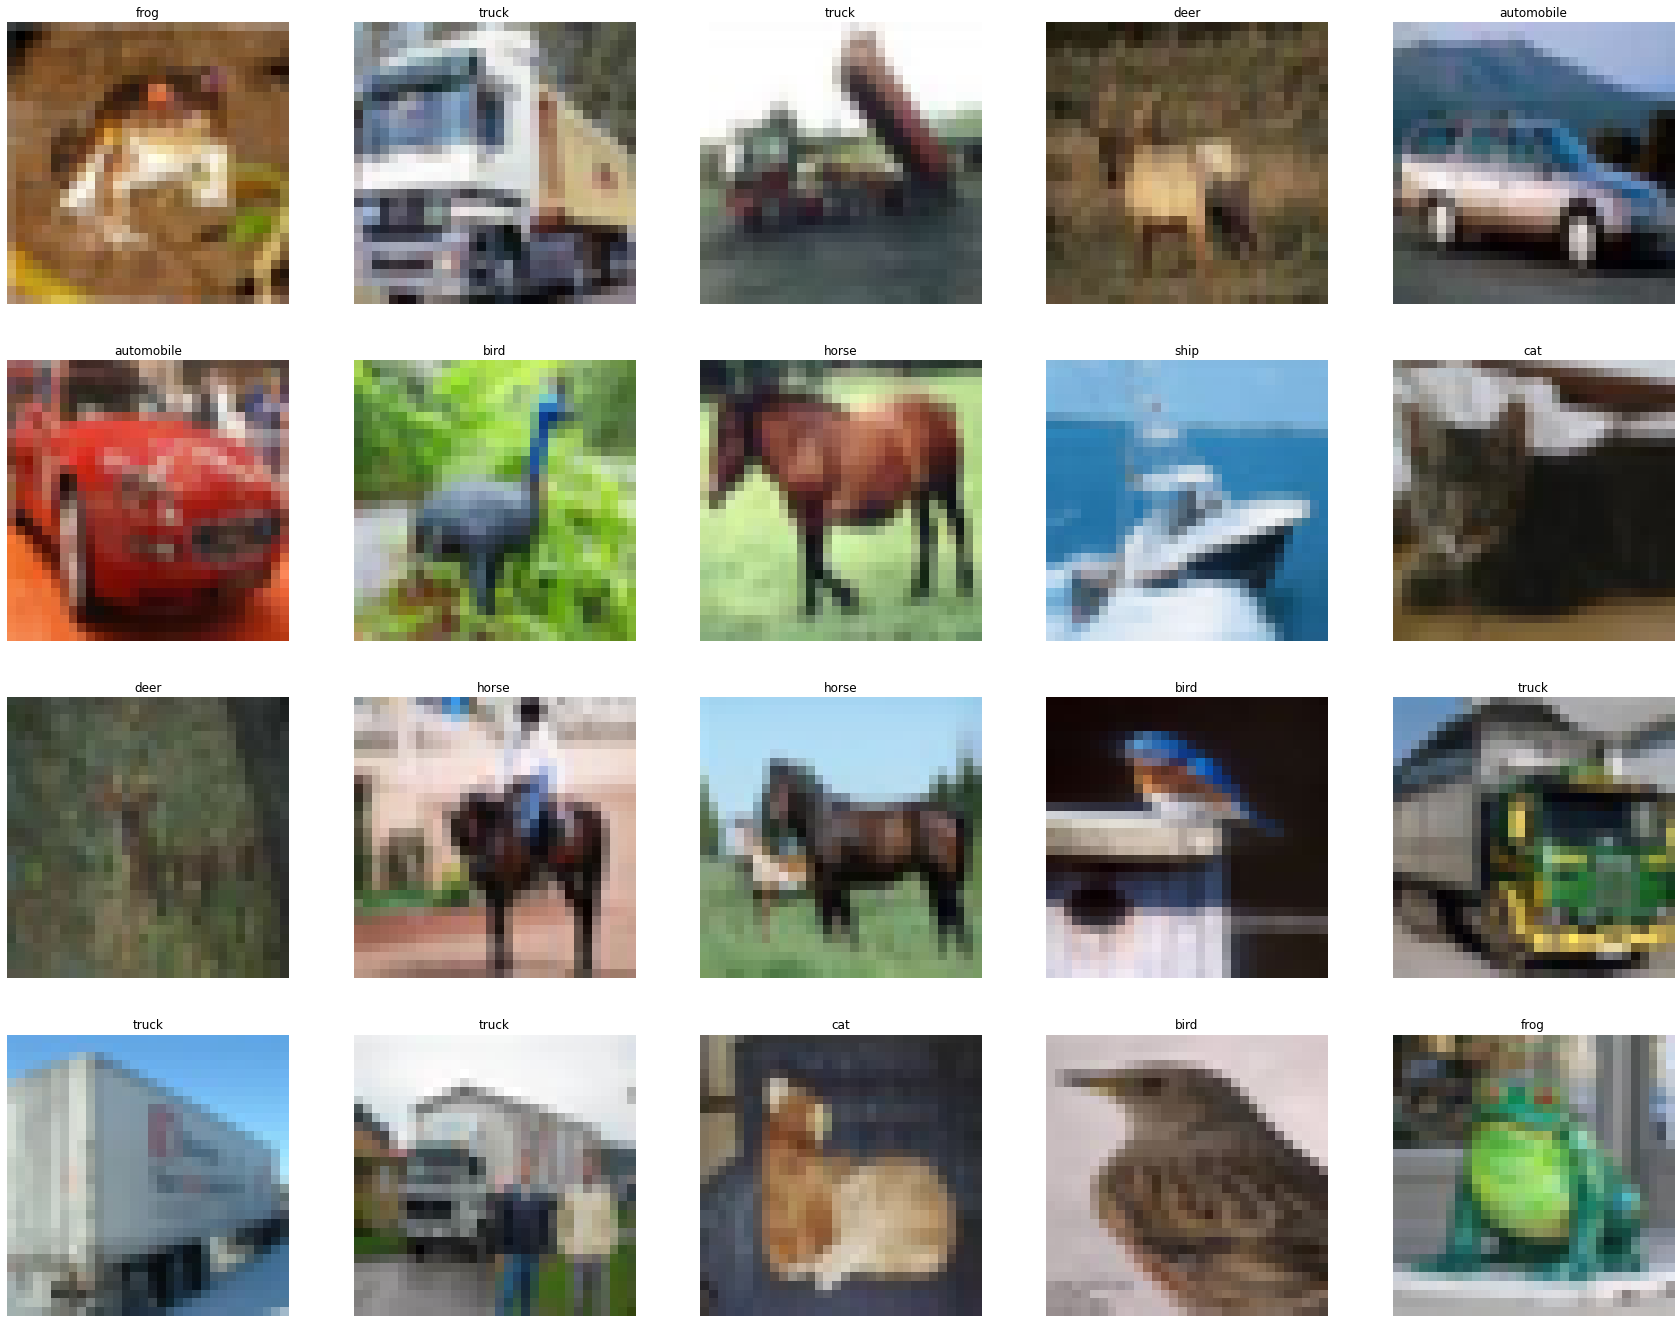

In [ ]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

Создадим функцию под process_images. Эта функция выполнит всю необходимую предварительную обработку данных. Эта функция будет вызываться далее в рабочем процессе машинного обучения.

In [ ]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

Мы получили и разбили набор данных и создали функцию для обработки набора данных. Следующим шагом создадим входной конвейер для последовательного запуска функций и методов

In [ ]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


Для нашего основного конвейера ввода / данных мы проведем три основные операции:
1. Предварительная обработка данных в наборе данных
2. Перемешивание набора данных.
3. Пакетные данные в наборе данных.

In [ ]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

Реализация модели

Реализуем архитектуру AlexNet CNN с нуля. 

Модель состоит из следующих слоев:

Convolutional layer - свёрточный слой. Насколько я понял, свёртка - это замена количества пикселей равное ядру свёртки скалярному произведению ядна на такой же кусок из исходного изображения. 

Batch Normalisation layer - слой пакетной нормализации. Нашёл на каком-то сайте, что надо добавлять такой слой для смягчения влияние нестабильных градиентов в нейронной сети (что это такое, пока не понял, но добавим)

MaxPooling layer. Из лекции я не понял, что это такое, но сказали, что так надо, значит добавим его

Flatten layer - принимает входную форму и выравнивает данные входного изображения в одномерный массив.

Dense Layer это перцептрон


In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
    
    
])

Обучаем и компилируем модель

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 256)        

In [35]:
history=model.fit(
    train_ds,
    epochs=25,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/25
1562/1562 [==============================] - 492s 315ms/step - loss: 2.1793 - accuracy: 0.2345 - val_loss: 1.7019 - val_accuracy: 0.3944
Epoch 2/25
1562/1562 [==============================] - 487s 312ms/step - loss: 1.8030 - accuracy: 0.3448 - val_loss: 1.5502 - val_accuracy: 0.4462
Epoch 3/25
1562/1562 [==============================] - 487s 312ms/step - loss: 1.6538 - accuracy: 0.4012 - val_loss: 1.4603 - val_accuracy: 0.4843
Epoch 4/25
1562/1562 [==============================] - 492s 315ms/step - loss: 1.5437 - accuracy: 0.4395 - val_loss: 1.3924 - val_accuracy: 0.5047
Epoch 5/25
1562/1562 [==============================] - 490s 313ms/step - loss: 1.4543 - accuracy: 0.4781 - val_loss: 1.3503 - val_accuracy: 0.5193
Epoch 6/25
1562/1562 [==============================] - 497s 318ms/step - loss: 1.3712 - accuracy: 0.5091 - val_loss: 1.2935 - val_accuracy: 0.5420
Epoch 7/25
1562/1562 [==============================] - 499s 319ms/step - loss: 1.3080 - accuracy: 0.5297 - val_

In [36]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Теперь визуализируем тренировки в разные эпохи.

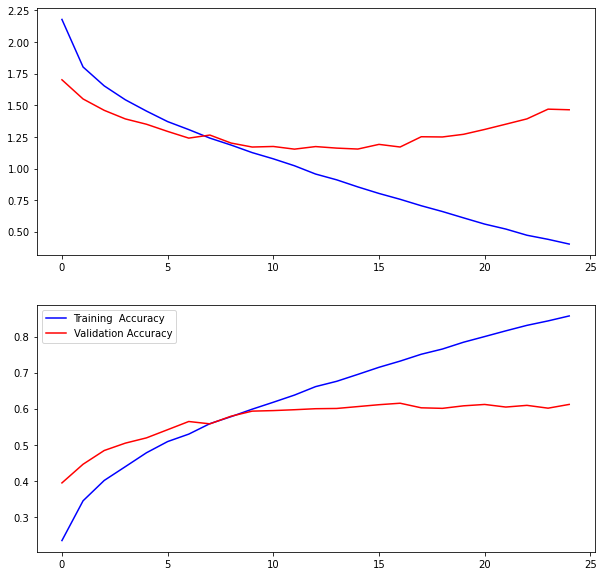

In [37]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [38]:
print('Accuracy Score = ',np.max(history.history['val_accuracy']))

Accuracy Score =  0.6153846383094788


При увеличении числа эпох до 50, accuracy увеличиловалось до 0,99 обучение почему-то остановилось.

Увеличение количества ядер позволяет выделить наибольшее количество деталей на картинке. В случае, если подобрать оптимальное количество ядер, результат улучшается. Если ядер очень много, то происходит ухудшение.

Увеличение количества свёрточных слоёв также улучшает результат.

Но при ограниченном количестве входных картинок, увеличение ядер и слоёв ведёт к переобучению, модель запоминает все картинки.  
